## Gradient descent and Linear Regression

We consider the diabetes dataset from `sklearn.datasets` with

- Features: $X \in \mathbb{R}^{442 \times 10}$
- Target: $Y \in \mathbb{R}^{442}$

We use the linear model

$$
f(x) = \sum_{j=1}^{10} x^{(j)} \beta_j + c.
$$

The mean squared error loss is

$$
L = \frac{1}{N} \| X\beta + c - Y \|_2^2,
$$

with $N = 442$.

To express this in matrix form, augment $X$ with a column of ones and define

$$
\theta = \begin{pmatrix} \beta \\ c \end{pmatrix}.
$$

Then the loss becomes

$$
L = \frac{1}{N} \| X\theta - Y \|_2^2.
$$

The following splits the data into training and test sets and implements gradient descent to minimise the loss.

In [ ]:
import matplotlib.pylab as plt

import numpy as np

import torch

%matplotlib inline

from sklearn import datasets

diabetes = datasets.load_diabetes()

X = torch.tensor(diabetes.data)

Y = torch.tensor(diabetes.target)

In [ ]:
# Create ones vector and append to last column of X

ones = torch.ones((X.shape[0], 1))

X_c = torch.cat((X, ones), 1)

print(X_c.shape)

torch.Size([442, 11])


In [ ]:
# Set size of total dataset, training set, and test set

N = 442

training_size = 353

test_size = N - training_size

# Use torch.randperm to randomise vector and split training and test set as follows

indices = torch.randperm(N)

training_indices = indices[:training_size]
test_indices = indices[training_size:]

X_training = X_c[training_indices]
Y_training = Y[training_indices]

X_test = X_c[test_indices]
Y_test = Y[test_indices]

In [ ]:
# Matrix form of least squares estimator

theta_LS = torch.linalg.inv(X_training.T @ X_training) @ X_training.T @ Y_training

# Compute the predicted values for the test set using the least squares estimator on the test data

Y_test_fitted = X_test @ theta_LS

# MSE...

test_error = torch.mean((Y_test - Y_test_fitted) ** 2)

print(test_error)

tensor(2810.6386, dtype=torch.float64)


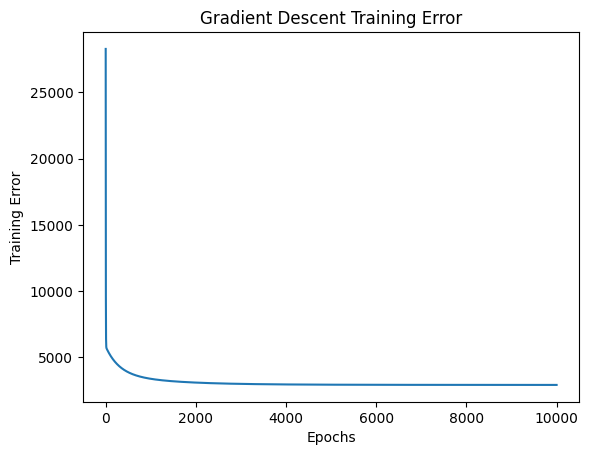

LSE Test Error: 2810.6386120004313
GD Test Error: 8976.602141195612


In [ ]:
# When computing grad, it was raising an error due to the shape of Y_training,
# so I made sure it had the correct dimensions

Y_training = Y_training.reshape(-1, 1)

# Set new N (training set size), learning rate, and epochs

N = X_training.shape[0]

lr = 0.1

epochs = 10000

# Initialise theta and array to store training errors

theta_GD = torch.zeros((X_training.shape[1], 1), dtype = torch.float64)

training_errors = []

for epoch in range(epochs):

  # Compute training errors using LS, and append to array

  Y_training_fitted = X_training @ theta_GD

  training_error = torch.mean((Y_training - Y_training_fitted) ** 2)

  training_errors.append(training_error.item())

  # Calculate gradient and implement GD algorithm

  grad = (2 / N) * (X_training.T @ (Y_training_fitted - Y_training))

  theta_GD -= lr * grad

# Calculate test error for GD, and display training errors on graph

Y_test_fitted_GD = X_test @ theta_GD

test_error_GD = torch.mean((Y_test - Y_test_fitted_GD) ** 2)

plt.plot(range(epochs), training_errors)
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.title("Gradient Descent Training Error")
plt.show()

print("LSE Test Error:", test_error.item())
print("GD Test Error:", test_error_GD.item())

Clearly, the GD error is a lot less than the LSE error for the test set.

## Regularised Least Squares

We consider a dataset of the form $A \in \mathbb{R}^{n \times n}$ and $b \in \mathbb{R}^n$,  
where $n = 1000$, provided as two CSV files: `A.csv` and `b.csv`.

We want to solve the following regularised inverse problem:

$$
\min_{x \in \mathbb{R}^n} \;
L(x) = \|Ax - b\|_2^2 + \lambda \|x\|_2^2,
$$

where $\lambda \in [0, 1]$ is a regularization parameter.

$\frac{\partial L}{\partial \mathbf{x}} = -2 A ^ T \mathbf{b} + 2 A ^ T A \mathbf{x} + 2 \lambda \mathbf{x}$

To minimise, we set this equal to zero, giving

$A ^ T A \mathbf{x} + \lambda \mathbf{x} = A ^ T \mathbf{b}$

$\implies (A ^ T A + \lambda I) \mathbf{x} = A ^ T \mathbf{b}$

$\implies \mathbf{x} = (A ^ T A + \lambda I) ^ {-1}  A ^ T \mathbf{b}$

In [ ]:
# Upload files to colab

from google.colab import files

mydata = files.upload()

mydata.keys()

Saving A.csv to A.csv
Saving b.csv to b.csv


dict_keys(['A.csv', 'b.csv'])

In [ ]:
# Use pandas for ease, convert to tensors

import pandas as pd

file_A = "A.csv"
file_b = "b.csv"

A_pd = pd.read_csv(file_A, header = None)
b_pd = pd.read_csv(file_b, header = None)

A = torch.tensor(A_pd.values)
b = torch.tensor(b_pd.values)

In [ ]:
# Set size of total dataset, training set, and test set

N = 1000

training_size = 800

test_size = N - training_size

# Use torch.randperm to randomise vector and split training and test set as follows

indices = torch.randperm(N)

training_indices = indices[:training_size]
test_indices = indices[training_size:]

A_training = A[training_indices]
b_training = b[training_indices]

A_test = A[test_indices]
b_test = b[test_indices]

In [ ]:
# Least squares estimator

x_LS = torch.linalg.inv(A_training.T @ A_training) @ A_training.T @ b_training

# Predicted values

b_test_fitted = A_test @ x_LS

# MSE...

test_error = torch.mean((b_test - b_test_fitted) ** 2)

print(test_error)

tensor(3.2277e+24, dtype=torch.float64)


In [ ]:
# Set parameters

lr = 0.1

lmbda = 0

epochs = 1000

# Initialise x

x_GD = torch.zeros((A_training.shape[1], 1), dtype = torch.float64, requires_grad=True)

L_values = []

# Gradient descent

for epochs in range(epochs):

  L = torch.norm(A_training @ x_GD - b_training, p = 2) ** 2 + lmbda * torch.norm(x_GD, p = 2) ** 2

  # Use autograd for GD

  L.backward()

  with torch.no_grad():

    x_GD -= lr * x_GD.grad

  x_GD.grad.zero_()

  L_values.append(L.item())

b_test_fitted_GD = A_test @ x_GD

test_error_GD = torch.mean((b_test - b_test_fitted_GD) ** 2)

print("LSE Test Error:", test_error)
print("GD Test Error:", test_error_GD)

LSE Test Error: tensor(3.2277e+24, dtype=torch.float64)
GD Test Error: tensor(5.0405e-07, dtype=torch.float64, grad_fn=<MeanBackward0>)


The GD Test error is very small, whereas the LSE Test error is extremely large.

In [ ]:
# Set lambda values and loop over

lambda_vals = torch.logspace(-8, 0, steps = 10)

test_errors = []

for lmbda in(lambda_vals):

  x_GD = torch.zeros((A_training.shape[1], 1), dtype = torch.float64, requires_grad=True)

  for epochs in range(epochs):

    # GD as before

    L = torch.norm(A_training @ x_GD - b_training, p = 2) ** 2 + lmbda * torch.norm(x_GD, p = 2) ** 2

    L.backward()

    with torch.no_grad():

      x_GD -= lr * x_GD.grad

    x_GD.grad.zero_()

  # Calculate predicted values for each step in the outer loop and append

  b_test_fitted_GD = A_test @ x_GD

  test_error_GD = torch.mean((b_test - b_test_fitted_GD) ** 2)

  test_errors.append(test_error_GD.item())

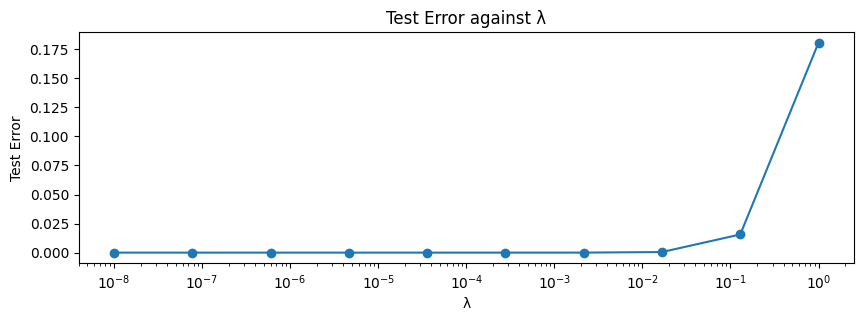

In [ ]:
# Convert for easier plotting

lambda_vals = lambda_vals.tolist()

test_errors = np.array(test_errors)


plt.figure(figsize=(10,3))
plt.plot(lambda_vals, test_errors, marker='o', linestyle='-')

plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Test Error")
plt.title("Test Error against λ")
plt.show()

We should choose $\lambda \in [10 ^ {-8}, 10 ^ {-2}]$, as within this range the test error is the smallest. It clearly increases with bigger $\lambda$. Going towards the higher end of this range would be wise, as it means we penalise smaller parameters values. This is a desirable property as smaller parameter values are less indicative of correlation, so we'd like to reduce their effects. I'd pick $\lambda \in [10 ^ {-3}, 10 ^ {-2}].$